In [3]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

Dataset retirado de uma competição do kaggle: https://www.kaggle.com/c/customer-churn-prediction-2020/overview

This competition is about predicting whether a customer will change telecommunications provider, something known as "churning".

The training dataset contains 4250 samples. Each sample contains 19 features and 1 boolean variable "churn" which indicates the class of the sample. The 19 input features and 1 target variable are:

- **"state"**, string. 2-letter code of the US state of customer residence
- **"account_length"**, numerical. Number of months the customer has been with the current telco provider
- **"area_code"**, string="area_code_AAA" where AAA = 3 digit area code.
- **"international_plan"**, yes/no. The customer has international plan.
- **"voice_mail_plan"**, yes/no. The customer has voice mail plan.
- **"number_vmail_messages"**, numerical. Number of voice-mail messages.
- **"total_day_minutes"**, numerical. Total minutes of day calls.
- **"total_day_calls"**, numerical. Total minutes of day calls.
- **"total_day_charge"**, numerical. Total charge of day calls.
- **"total_eve_minutes"**, numerical. Total minutes of evening calls.
- **"total_eve_calls"**, numerical. Total number of evening calls.
- **"total_eve_charge"**, numerical. Total charge of evening calls.
- **"total_night_minutes"**, numerical. Total minutes of night calls.
- **"total_night_calls"**, numerical. Total number of night calls.
- **"total_night_charge"**, numerical. Total charge of night calls.
- **"total_intl_minutes"**, numerical. Total minutes of international calls.
- **"total_intl_calls"**, numerical. Total number of international calls.
- **"total_intl_charge"**, numerical. Total charge of international calls
- **"number_customer_service_calls"**, numerical. Number of calls to customer service
- **"churn"**, yes/no. Customer churn - target variable.

In [5]:
train_data = pd.read_csv("data/train.csv")

In [24]:
train_data[['churn', 'total_night_minutes']].groupby('churn').count()

,total_night_minutes
churn,
no,3652
yes,598


In [6]:
train_data.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


# Explorando qualidade do dado

In [7]:
train_data.isnull().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [10]:
train_data.select_dtypes(include = 'object').head()

,state,area_code,international_plan,voice_mail_plan,churn
0,OH,area_code_415,no,yes,no
1,NJ,area_code_415,no,no,no
2,OH,area_code_408,yes,no,no
3,OK,area_code_415,yes,no,no
4,MA,area_code_510,no,yes,no


In [11]:
for column in train_data.select_dtypes(include='object').columns:
    print(f"Values of column {column}: {train_data[column].unique()} \n")

Values of column state: ['OH' 'NJ' 'OK' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY' 'ID' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'SC' 'WY' 'HI' 'NH' 'AK' 'GA' 'MD' 'AR' 'WI' 'OR'
 'MI' 'DE' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'VT' 'KY' 'ME'
 'MS' 'AL' 'NE' 'KS' 'TN' 'IL' 'PA' 'CT' 'ND'] 

Values of column area_code: ['area_code_415' 'area_code_408' 'area_code_510'] 

Values of column international_plan: ['no' 'yes'] 

Values of column voice_mail_plan: ['yes' 'no'] 

Values of column churn: ['no' 'yes'] 



# Exploração de correlação entre as variáveis

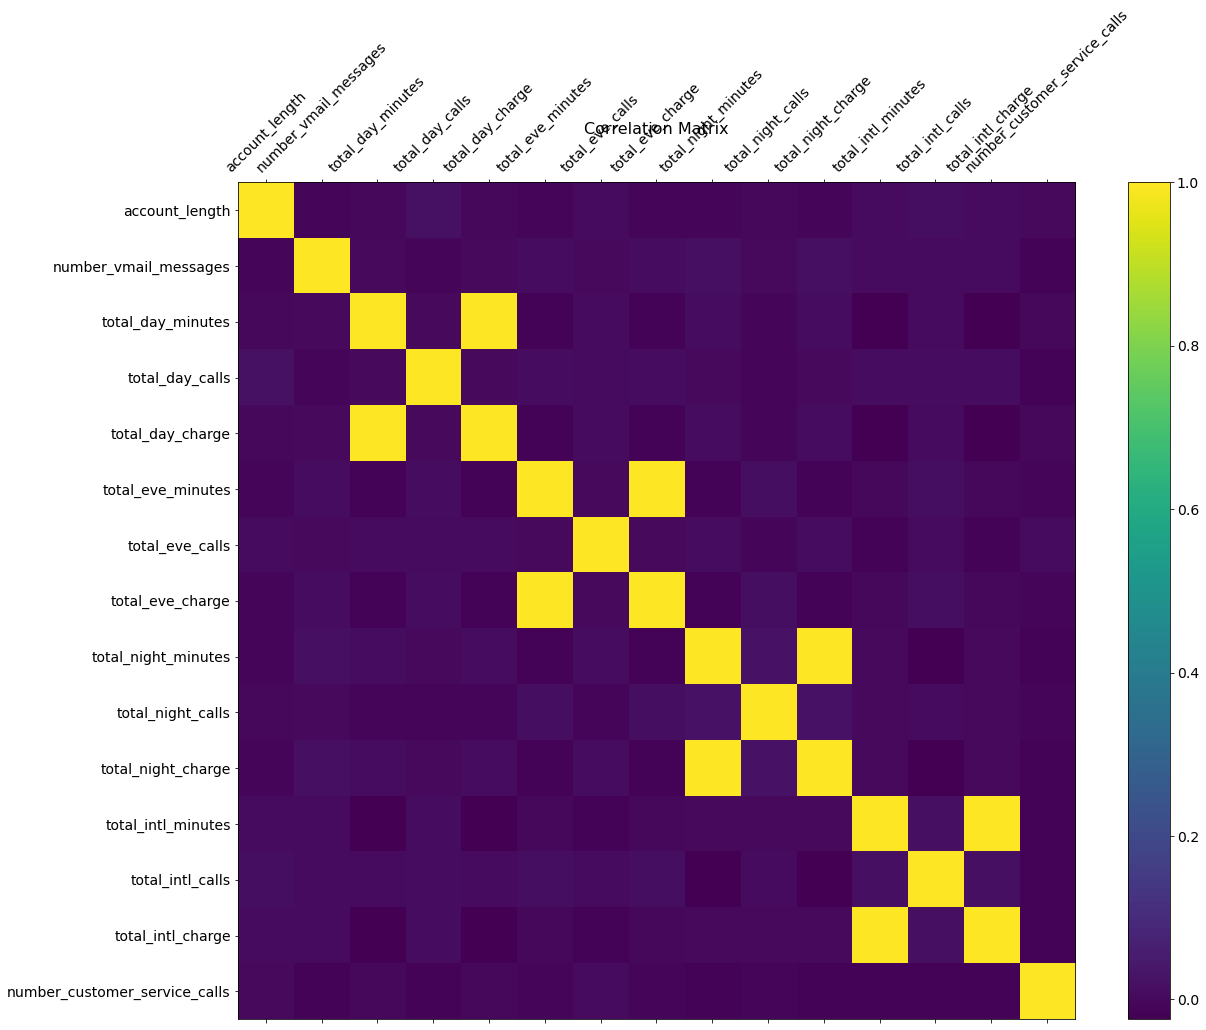

In [12]:
f = plt.figure(figsize=(19, 15))
df = train_data.select_dtypes(exclude = 'object')
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## Covariáveis Categóricas versus resposta

In [13]:
def generate_grouped_dataset_to_prop_plot(df, x_column, split_column, aux_column='account_length'):
    grouped = df[[split_column, x_column, aux_column]].groupby([x_column, split_column]).count()
    state = df[[x_column,  aux_column]].groupby([x_column]).count()
    prop_data = grouped.div(state, level = x_column).reset_index().rename(columns = {aux_column: 'prop'})
    return prop_data

In [14]:
prop_data = generate_grouped_dataset_to_prop_plot(train_data, 'state', 'churn')

Text(0.5, 1.0, 'state')

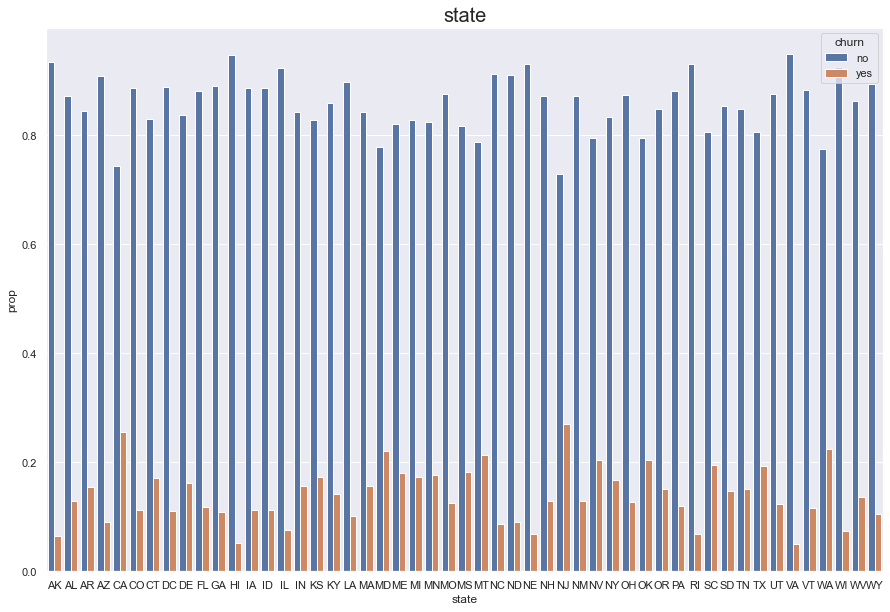

In [16]:
sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(x='state',y='prop',data=prop_data, hue='churn')
plt.title('state', fontsize=20)

Text(0.5, 1.0, 'area_code')

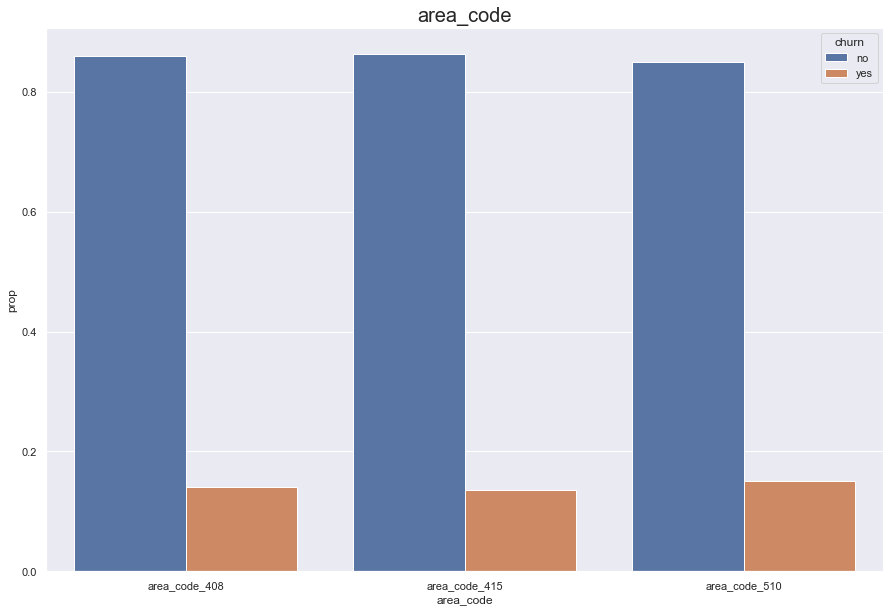

In [17]:
sns.set(rc={'figure.figsize':(15,10)})
prop_data = generate_grouped_dataset_to_prop_plot(train_data, 'area_code', 'churn')
sns.barplot(x='area_code',y='prop',data=prop_data, hue='churn')
plt.title('area_code', fontsize=20)

Text(0.5, 1.0, 'international_plan')

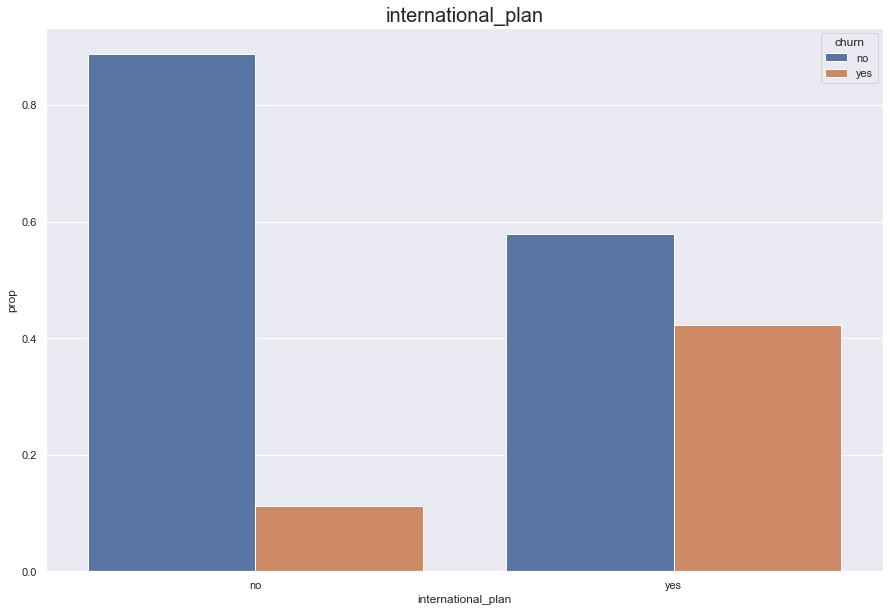

In [18]:
sns.set(rc={'figure.figsize':(15,10)})
prop_data = generate_grouped_dataset_to_prop_plot(train_data, 'international_plan', 'churn')
sns.barplot(x='international_plan',y='prop',data=prop_data, hue='churn')
plt.title('international_plan', fontsize=20)

Text(0.5, 1.0, 'voice_mail_plan')

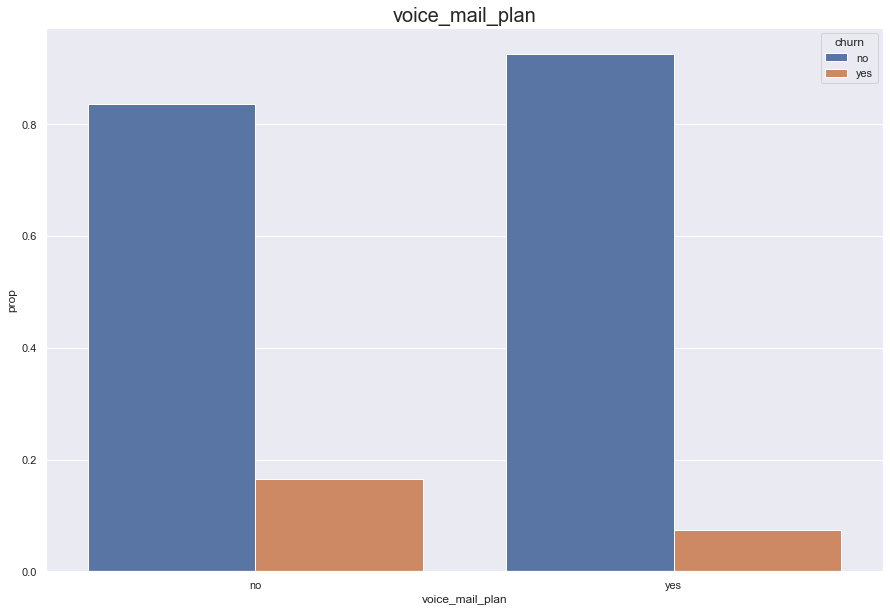

In [19]:
sns.set(rc={'figure.figsize':(15,10)})
prop_data = generate_grouped_dataset_to_prop_plot(train_data, 'voice_mail_plan', 'churn')
sns.barplot(x='voice_mail_plan',y='prop',data=prop_data, hue='churn')
plt.title('voice_mail_plan', fontsize=20)

## Covaráveis numéricas versus Resposta

In [20]:
def make_dist_plot(x, hue, data):
    sns.set(rc={'figure.figsize':(15,10)})
    sns.set(font_scale = 1)
    sns.histplot(data=data, 
                 x=x, 
                 hue=hue, 
                 multiple="dodge",
                 element="poly",
                 stat="density")
    plt.title(x, fontsize=20)
    plt.show()

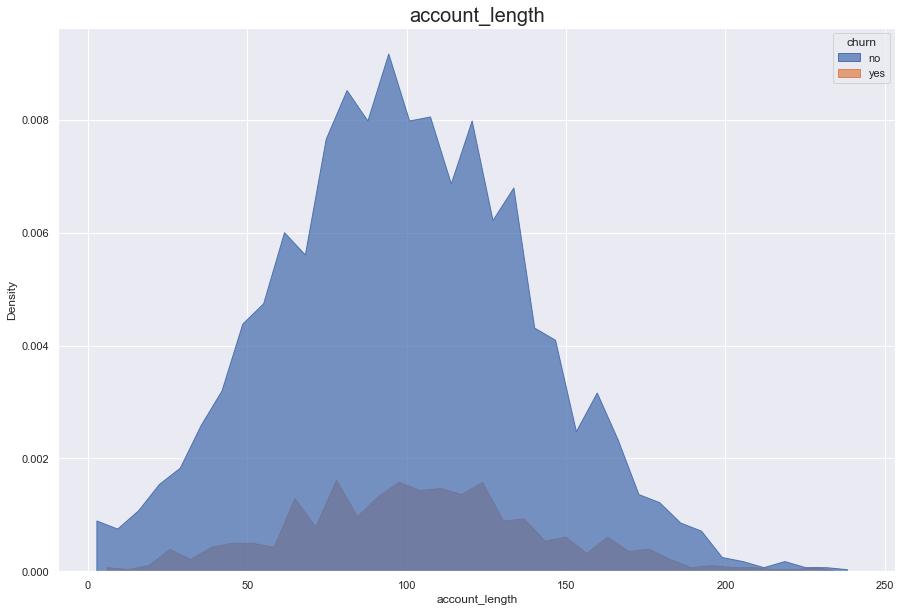

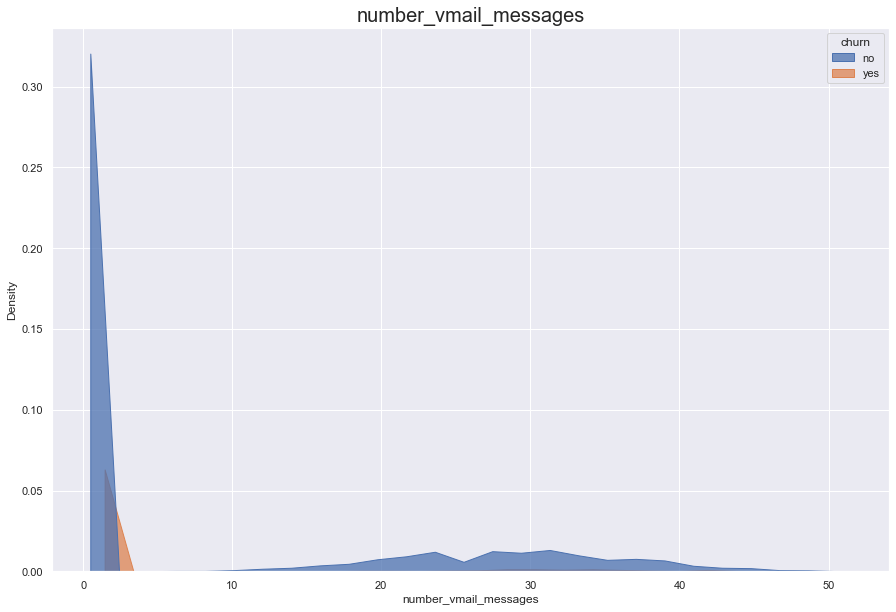

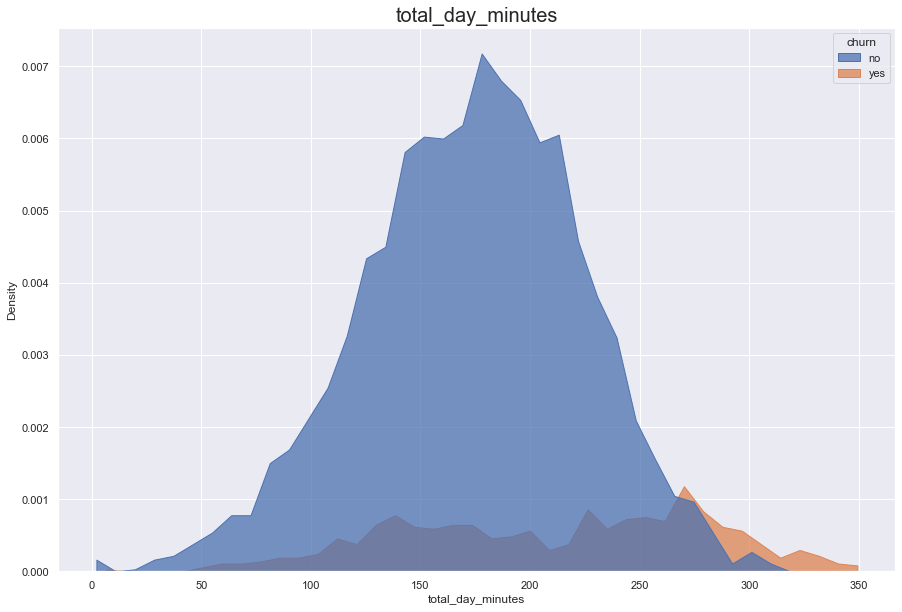

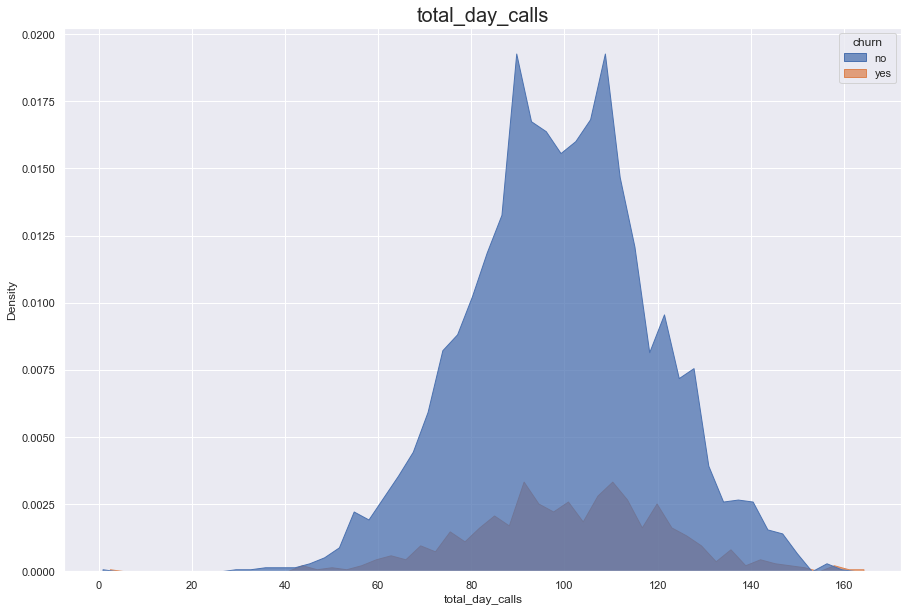

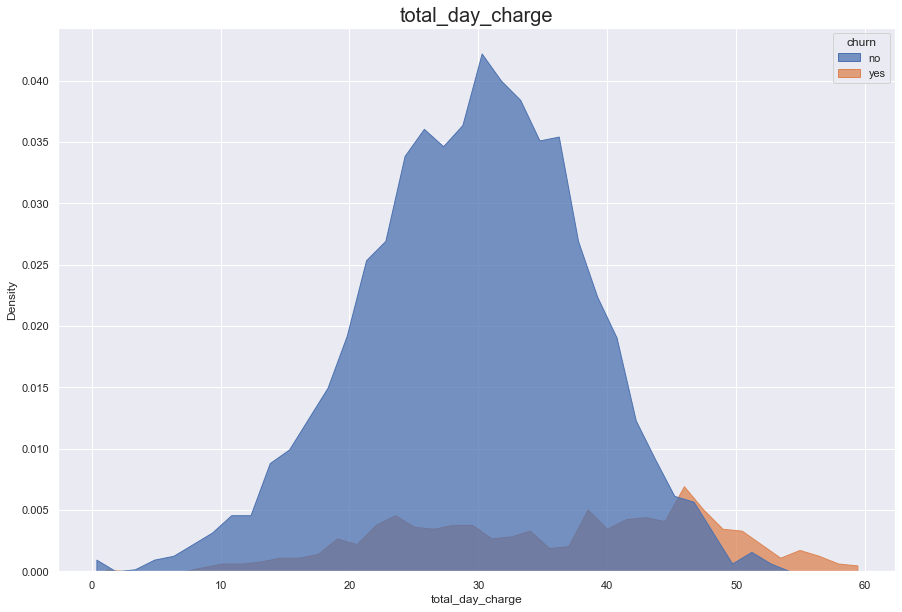

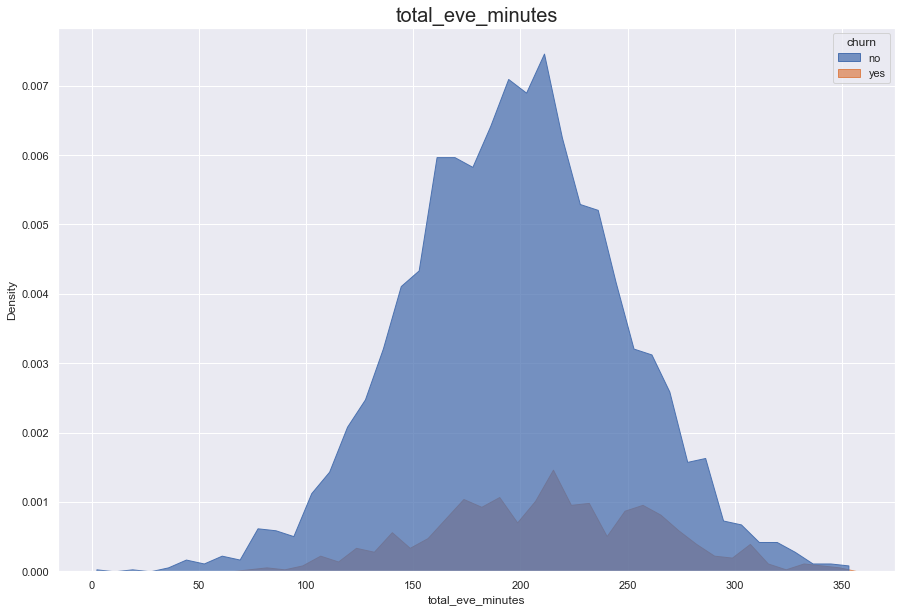

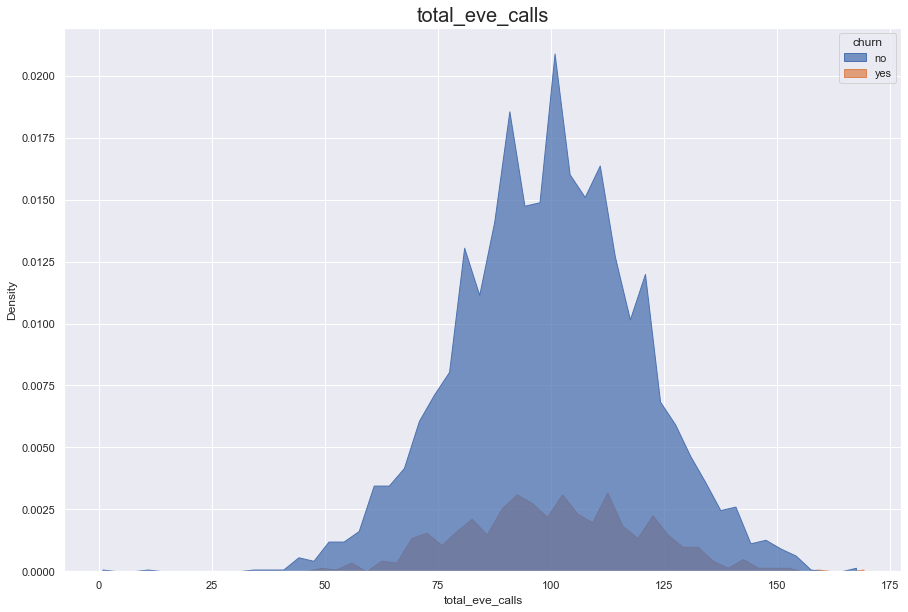

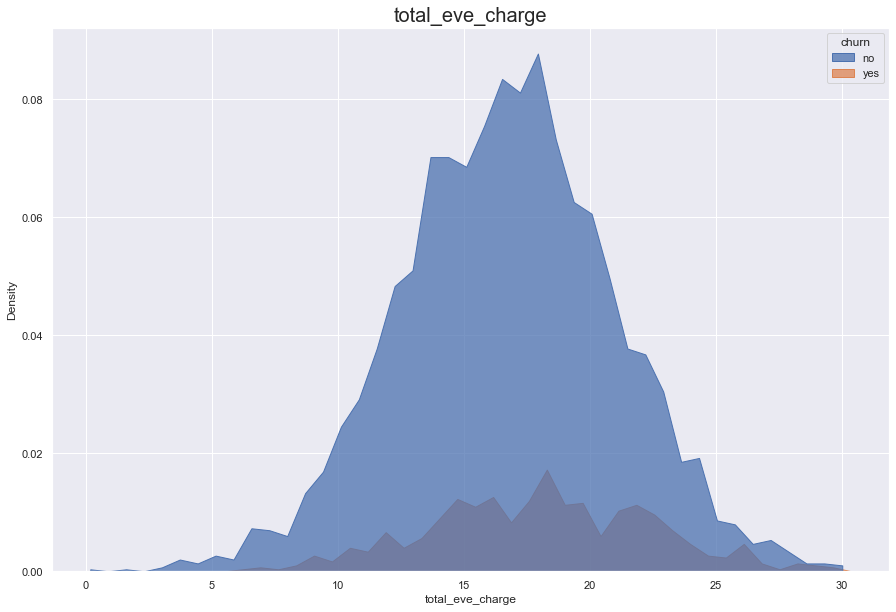

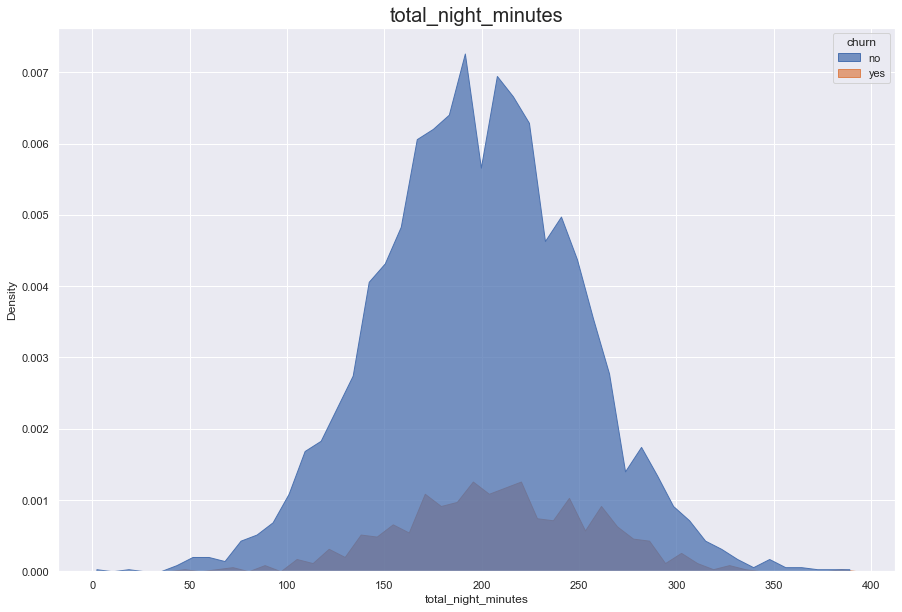

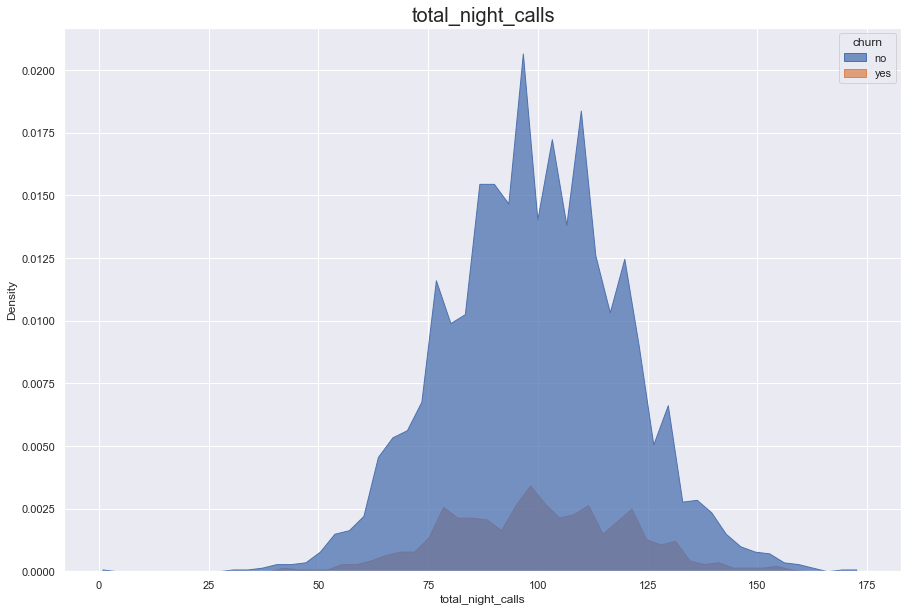

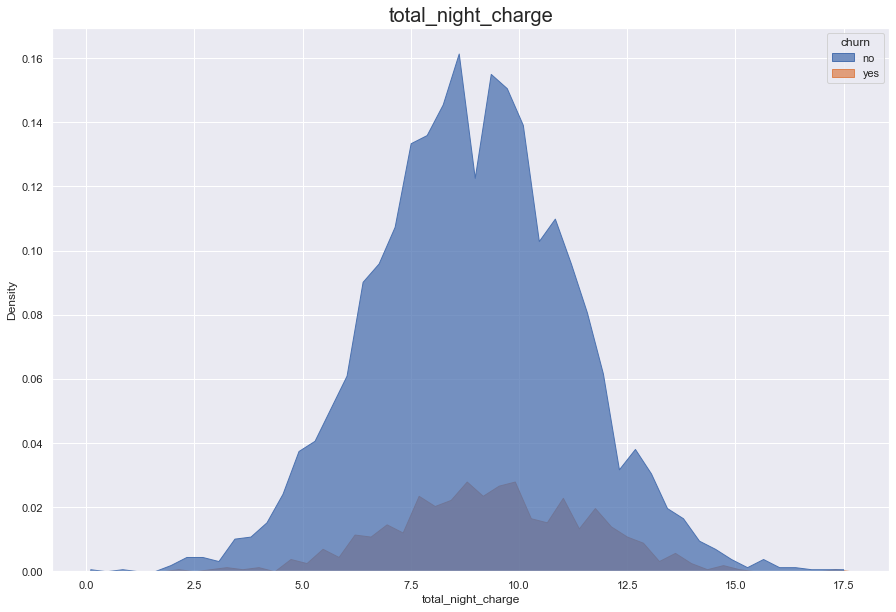

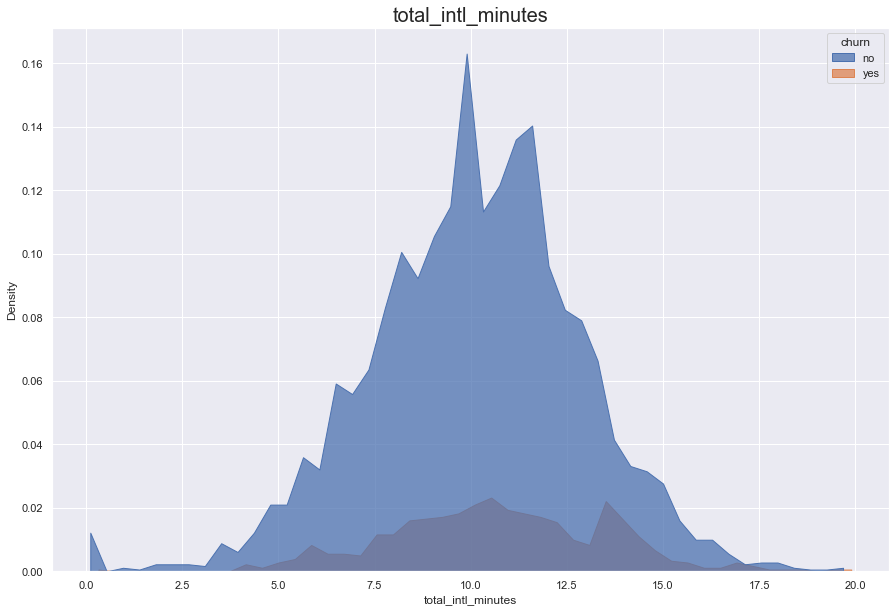

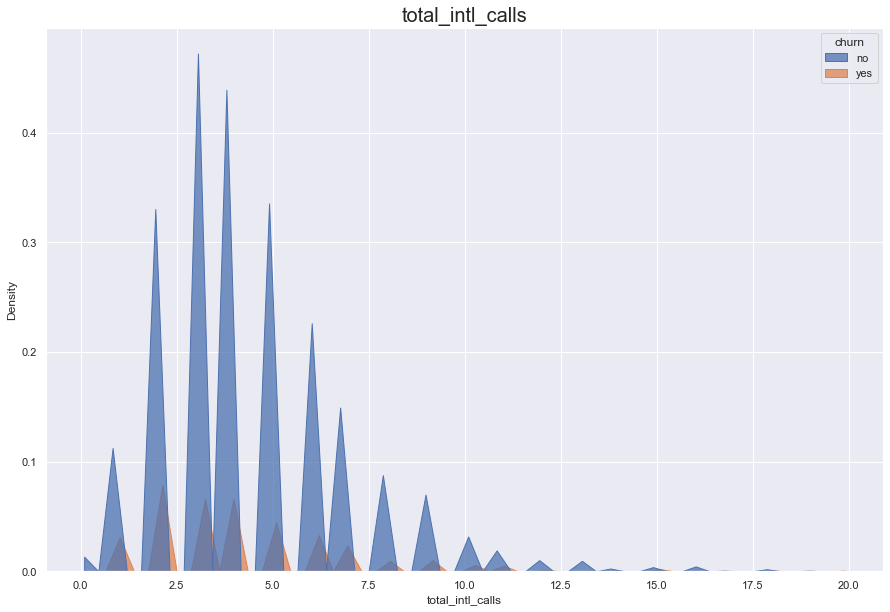

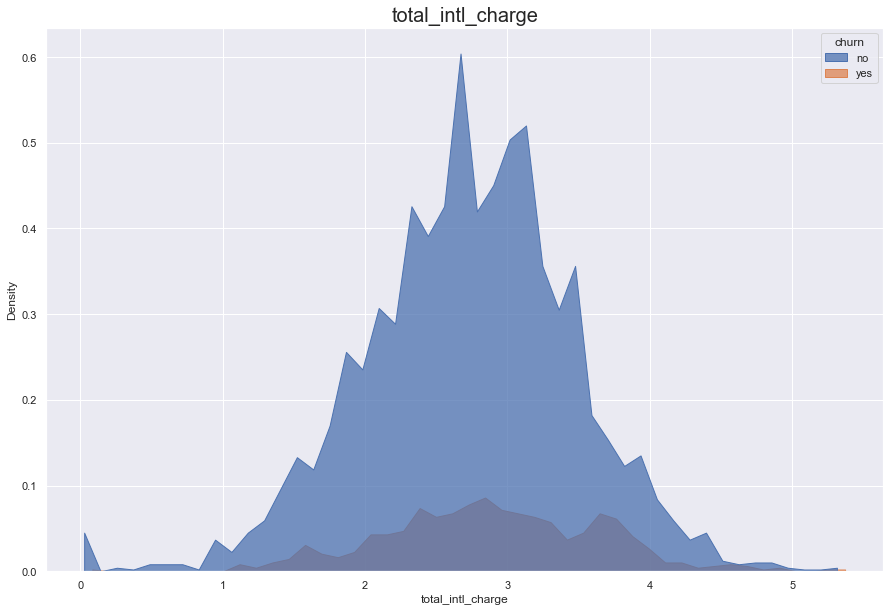

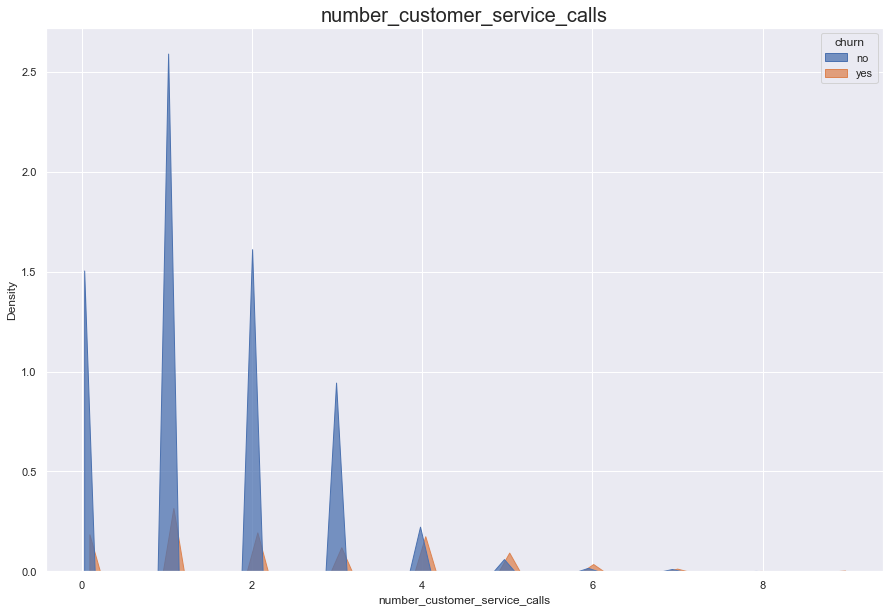

In [21]:
for variables in train_data.select_dtypes(exclude = 'object').columns:
    make_dist_plot(x = variables,
                   hue = 'churn',
                   data = train_data)

# Modelagem

## Balanceando o dataset e transformando as categóricas em binárias

In [25]:
# getting dummies variables
dummies_data = pd.get_dummies(train_data[['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']], drop_first=True)
enc_train_data = train_data.join(dummies_data)
enc_train_data = enc_train_data.drop(['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn'], axis = 1)

X = enc_train_data.drop('churn_yes', axis = 1)
y = enc_train_data[['churn_yes']]

In [26]:
enc_train_data

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes,churn_yes
0,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0,0,0,0,0,1,0,0,1,0
1,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,0,0,0,0,0,1,0,0,0,0
2,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,0,0,0,0,0,0,0,1,0,0
3,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,0,0,0,0,0,1,0,1,0,0
4,121,24,218.2,88,37.09,348.5,108,29.62,212.6,118,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,83,0,188.3,70,32.01,243.8,88,20.72,213.7,79,...,0,0,0,0,0,1,0,0,0,0
4246,73,0,177.9,89,30.24,131.2,82,11.15,186.2,89,...,0,0,0,1,0,0,0,0,0,0
4247,75,0,170.7,101,29.02,193.1,126,16.41,129.1,104,...,0,0,0,0,0,0,0,0,0,0
4248,50,40,235.7,127,40.07,223.0,126,18.96,297.5,116,...,0,0,0,0,0,0,0,0,1,0


In [27]:
#balancing dataset
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.9)

steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)

# transform the dataset
X_res, y_res = pipeline.fit_resample(X, y)

In [28]:
X_res

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes
0,143,0,202.800000,109,34.480000,165.800000,104,14.090000,143.900000,71,...,0,0,0,0,1,0,0,1,0,0
1,57,0,85.900000,92,14.600000,193.900000,127,16.480000,231.500000,93,...,0,0,0,0,0,0,1,0,0,0
2,75,0,138.500000,110,23.550000,153.200000,86,13.020000,215.600000,103,...,0,0,0,0,0,0,1,0,0,0
3,176,23,283.200000,130,48.140000,162.600000,74,13.820000,177.700000,104,...,0,0,0,0,0,0,1,0,0,1
4,148,25,230.700000,102,39.220000,233.800000,109,19.870000,215.800000,90,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306,104,0,296.946667,82,50.479762,185.298466,89,15.747784,270.015932,92,...,0,0,0,0,0,0,1,0,0,0
2307,74,0,110.852762,88,18.844970,263.376076,119,22.386235,184.832824,113,...,0,0,0,0,0,0,0,1,0,0
2308,78,0,316.850313,110,53.864194,225.423686,94,19.161077,163.851469,122,...,0,0,0,0,0,0,0,0,0,0
2309,91,0,215.984299,110,36.718000,181.010907,113,15.388826,258.172891,106,...,0,0,0,0,0,0,0,0,0,0


### Ajustando um modelo com dados desbalanceados

![recall_precision](recall_precision.png)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.90      0.64      0.75       735
         yes       0.19      0.52      0.27       115

    accuracy                           0.63       850
   macro avg       0.54      0.58      0.51       850
weighted avg       0.80      0.63      0.68       850



### Ajustando um modelo com dados balanceados

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.73      0.60      0.65       248
         yes       0.61      0.74      0.67       215

    accuracy                           0.66       463
   macro avg       0.67      0.67      0.66       463
weighted avg       0.67      0.66      0.66       463



### Testando transformar as variáveis com PCA

In [64]:
#padronizando + PCA
numerical_columns = ['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls']

categorical_columns = ['state_AL', 'state_AR', 'state_AZ',
       'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
       'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME',
       'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC',
       'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV',
       'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA',
       'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY',
       'area_code_area_code_415', 'area_code_area_code_510',
       'international_plan_yes', 'voice_mail_plan_yes']

In [65]:
pca = PCA(n_components=10)
std = StandardScaler()
std.fit(X_train[numerical_columns])

std_X_train = std.transform(X_train[numerical_columns])
pca.fit(std_X_train)

PCA(n_components=10)

In [66]:
pca.explained_variance_ratio_.sum()

0.9421810268944056

In [67]:
#criando dataset com colunas do PCA
X_pca_train = pd.DataFrame(pca.transform(std_X_train))
X_final_train = X_pca_train.join(X_train[categorical_columns].reset_index(drop = True))

In [68]:
#test dataset 
X_pca_test = pd.DataFrame(pca.transform(std.transform(X_test[numerical_columns])))
X_final_test = X_pca_test.join(X_test[categorical_columns].reset_index(drop = True))

In [69]:
gnb = GaussianNB()
y_pred = gnb.fit(X_final_train, y_train).predict(X_final_test)
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.73      0.59      0.65       248
         yes       0.61      0.74      0.67       215

    accuracy                           0.66       463
   macro avg       0.67      0.67      0.66       463
weighted avg       0.67      0.66      0.66       463



## Testando modelo com dados numéricos versus categóricos

In [25]:
X_numerical = X_res[numerical_columns]
X_categorical = X_res[categorical_columns]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y_res, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.74      0.77      0.76       248
         yes       0.72      0.68      0.70       215

    accuracy                           0.73       463
   macro avg       0.73      0.73      0.73       463
weighted avg       0.73      0.73      0.73       463



In [58]:
#ajustando dados apenas com categóricas e usando gaussianNB
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y_res, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.69      0.53      0.60       248
         yes       0.57      0.72      0.64       215

    accuracy                           0.62       463
   macro avg       0.63      0.63      0.62       463
weighted avg       0.63      0.62      0.62       463



In [111]:
#ajustando dados com categóricas e usando bernoulliNB
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y_res, test_size=0.2, random_state=0)
bnb = BernoulliNB()
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.72      0.71      0.71       248
         yes       0.67      0.68      0.67       215

    accuracy                           0.69       463
   macro avg       0.69      0.69      0.69       463
weighted avg       0.69      0.69      0.69       463



# Avaliando Modelo final: Variáveis numéricas

![recall_precision](recall_precision.png)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y_res, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.74      0.77      0.76       248
         yes       0.72      0.68      0.70       215

    accuracy                           0.73       463
   macro avg       0.73      0.73      0.73       463
weighted avg       0.73      0.73      0.73       463



Note que se por acaso sinalizarmos todos os usuários como possiveis churns, vamos acertar todos que de fato serão! porém, vamos errar todos que nao forem. Isso faz com que as métricas mudem bastante:

In [55]:
y_all_churn = [1]*y_test.shape[0]
print(classification_report(y_test, y_all_churn, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.00      0.00      0.00       248
         yes       0.46      1.00      0.63       215

    accuracy                           0.46       463
   macro avg       0.23      0.50      0.32       463
weighted avg       0.22      0.46      0.29       463



Por outro lado, se decidirmos sinalizar todos usuários como não churn, o contrário acontece:

In [54]:
y_none_churn = [0]*y_test.shape[0]
print(classification_report(y_test, y_none_churn, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.54      1.00      0.70       248
         yes       0.00      0.00      0.00       215

    accuracy                           0.54       463
   macro avg       0.27      0.50      0.35       463
weighted avg       0.29      0.54      0.37       463



# ROC curve

No Skill: ROC AUC=0.500
GNB: ROC AUC=0.683
BNB: ROC AUC=0.750


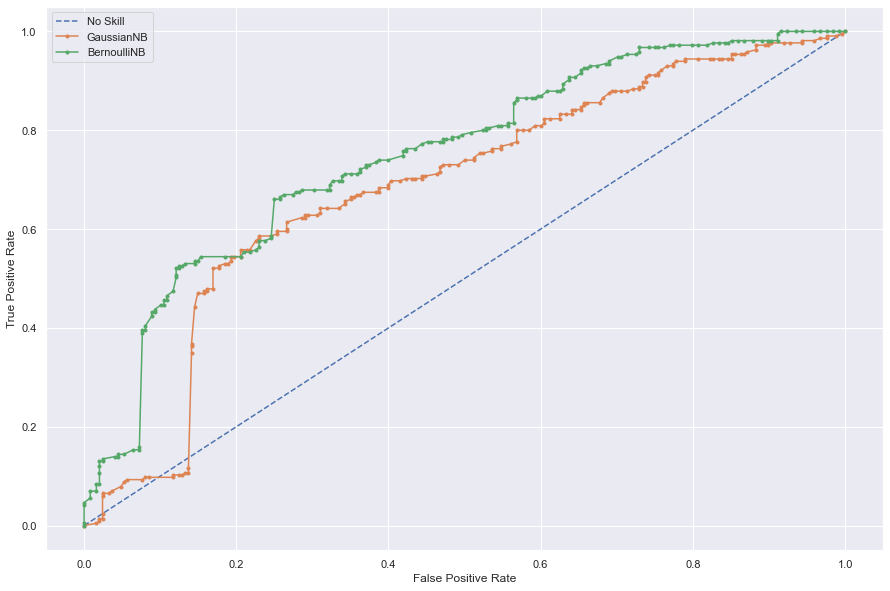

In [117]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

lr_probs = gnb.predict_proba(X_test)
bnb_probs = bnb.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
bnb_probs = bnb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
bnb_auc = roc_auc_score(y_test, bnb_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('GNB: ROC AUC=%.3f' % (lr_auc))
print('BNB: ROC AUC=%.3f' % (bnb_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
bnb_fpr, bnb_tpr, _ = roc_curve(y_test, bnb_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='GaussianNB')
pyplot.plot(bnb_fpr, bnb_tpr, marker='.', label='BernoulliNB')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()